<h1>Load Session

In [1]:
from one.api import ONE
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import seaborn as sns


parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from utils.load_meso_session import MesoscopeSession

one = ONE()
SESSION_INDEX = 0


In [2]:
# Load a session from the CSV file
session = MesoscopeSession.from_csv(one, '../good_mesoscope_sessions_final.csv', SESSION_INDEX)

In [3]:
session.eid

'61f260e7-b5d3-4865-a577-bcfc53fda8a8'

<h2> Summary Statistics

Activity matrix shape: (19081, 7673)
Session duration: 3935.1 seconds (65.6 minutes)

=== DATA OVERVIEW ===
Total neurons: 7673
Total timepoints: 19081
Sampling rate: 4.9 Hz
Sparsity: 0.864 (86.4% zeros)
Active neurons (>1% time): 7673/7673
Mean firing rate: 0.136


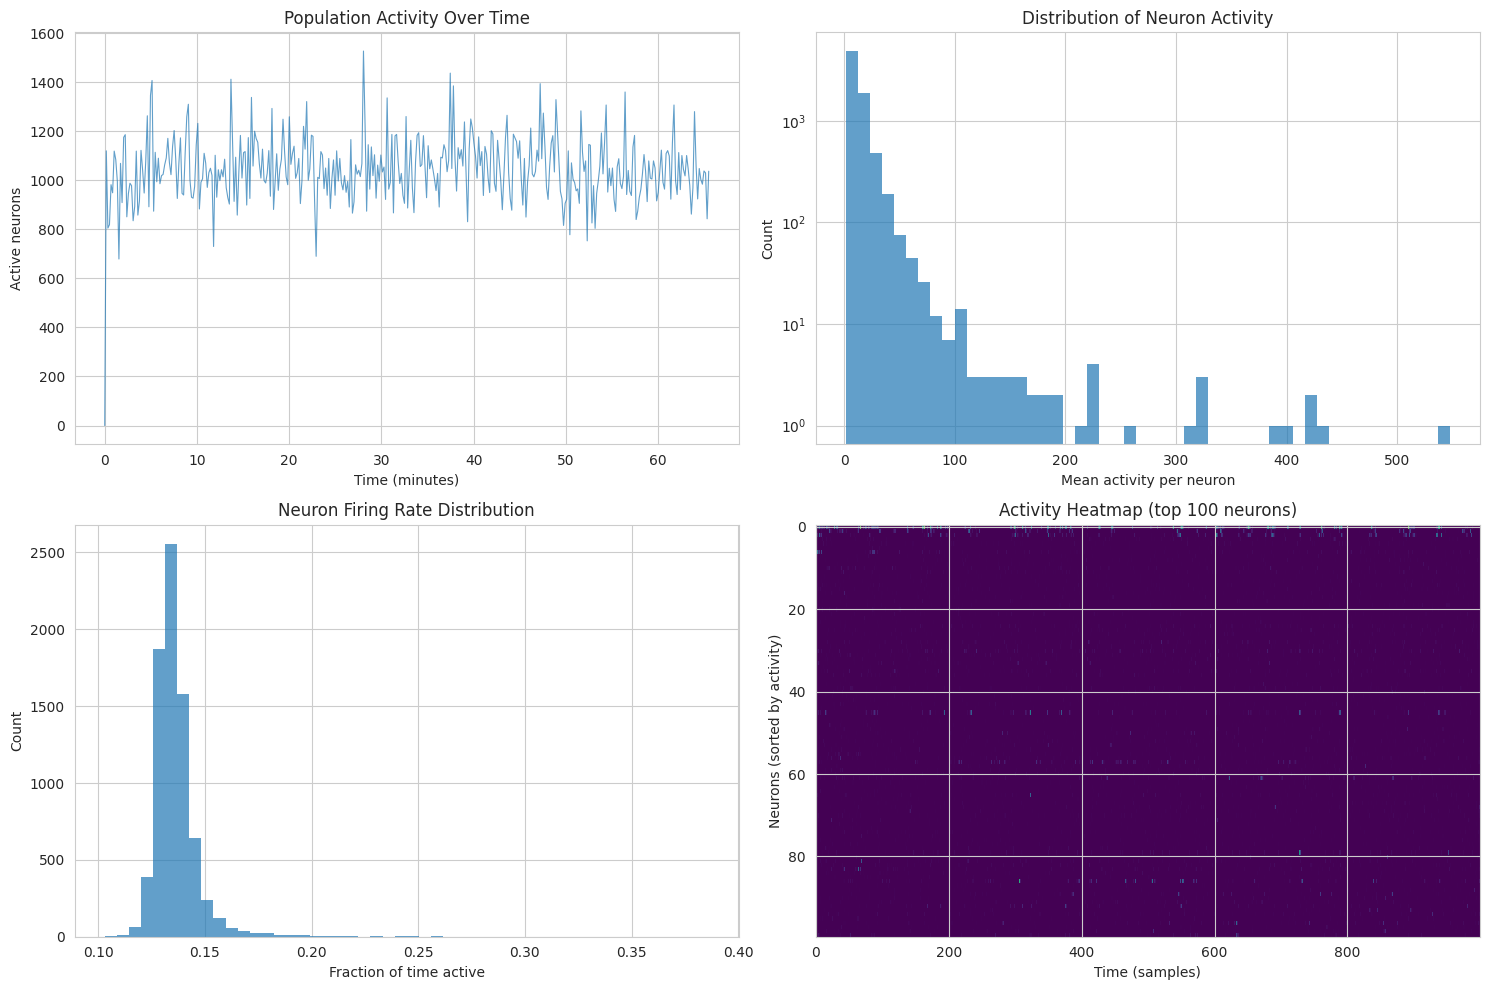


=== FOV BREAKDOWN ===
FOV_00: 1076 neurons (14.0%)
FOV_01: 1245 neurons (16.2%)
FOV_02: 1288 neurons (16.8%)
FOV_03: 546 neurons (7.1%)
FOV_04: 640 neurons (8.3%)
FOV_05: 431 neurons (5.6%)
FOV_06: 1018 neurons (13.3%)
FOV_07: 1429 neurons (18.6%)


In [4]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Get activity matrix
activity_matrix, timestamps = session.get_activity_matrix()
print(f"Activity matrix shape: {activity_matrix.shape}")
print(f"Session duration: {timestamps[-1]:.1f} seconds ({timestamps[-1]/60:.1f} minutes)")

# 1. DATA OVERVIEW & BASIC STATISTICS
print(f"\n=== DATA OVERVIEW ===")
print(f"Total neurons: {activity_matrix.shape[1]}")
print(f"Total timepoints: {activity_matrix.shape[0]}")
print(f"Sampling rate: {1/np.mean(np.diff(timestamps)):.1f} Hz")

# Basic activity statistics
total_events = np.sum(activity_matrix > 0.1)  # Using 0.1 as threshold for "active"
sparsity = 1 - (total_events / activity_matrix.size)
print(f"Sparsity: {sparsity:.3f} ({100*sparsity:.1f}% zeros)")

# Per-neuron statistics
neuron_firing_rates = np.mean(activity_matrix > 0.1, axis=0)  # Fraction of time active
neuron_mean_activity = np.mean(activity_matrix, axis=0)

print(f"Active neurons (>1% time): {np.sum(neuron_firing_rates > 0.01)}/{len(neuron_firing_rates)}")
print(f"Mean firing rate: {np.mean(neuron_firing_rates):.3f}")

# 2. POPULATION ACTIVITY OVER TIME
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Population sum over time (downsampled for visualization)
downsample_factor = 50  # Show every 50th timepoint
pop_activity = np.sum(activity_matrix > 0.1, axis=1)  # Number of active neurons per timepoint
time_ds = timestamps[::downsample_factor]
pop_ds = pop_activity[::downsample_factor]

axes[0,0].plot(time_ds/60, pop_ds, alpha=0.7, linewidth=0.8)
axes[0,0].set_xlabel('Time (minutes)')
axes[0,0].set_ylabel('Active neurons')
axes[0,0].set_title('Population Activity Over Time')

# Distribution of neuron activity levels
axes[0,1].hist(neuron_mean_activity, bins=50, alpha=0.7, edgecolor='none')
axes[0,1].set_xlabel('Mean activity per neuron')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Distribution of Neuron Activity')
axes[0,1].set_yscale('log')

# Firing rate distribution
axes[1,0].hist(neuron_firing_rates, bins=50, alpha=0.7, edgecolor='none')
axes[1,0].set_xlabel('Fraction of time active')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Neuron Firing Rate Distribution')

# Activity heatmap (sample of neurons)
n_sample = min(100, activity_matrix.shape[1])  # Sample 100 neurons
sample_idx = np.random.choice(activity_matrix.shape[1], n_sample, replace=False)
sample_idx = sample_idx[np.argsort(neuron_firing_rates[sample_idx])[::-1]]  # Sort by activity

# Downsample time for heatmap
time_sample = slice(0, min(1000, activity_matrix.shape[0]))  # First 1000 timepoints
heatmap_data = activity_matrix[time_sample, sample_idx].T

im = axes[1,1].imshow(heatmap_data, aspect='auto', cmap='viridis', interpolation='nearest')
axes[1,1].set_xlabel('Time (samples)')
axes[1,1].set_ylabel('Neurons (sorted by activity)')
axes[1,1].set_title(f'Activity Heatmap (top {n_sample} neurons)')

plt.tight_layout()
plt.show()

# 3. FOV BREAKDOWN
print(f"\n=== FOV BREAKDOWN ===")
for fov_name, fov in session.fovs.items():
    print(f"{fov_name}: {fov.n_neurons} neurons ({fov.n_neurons/session.n_total_neurons*100:.1f}%)")

<Axes: >

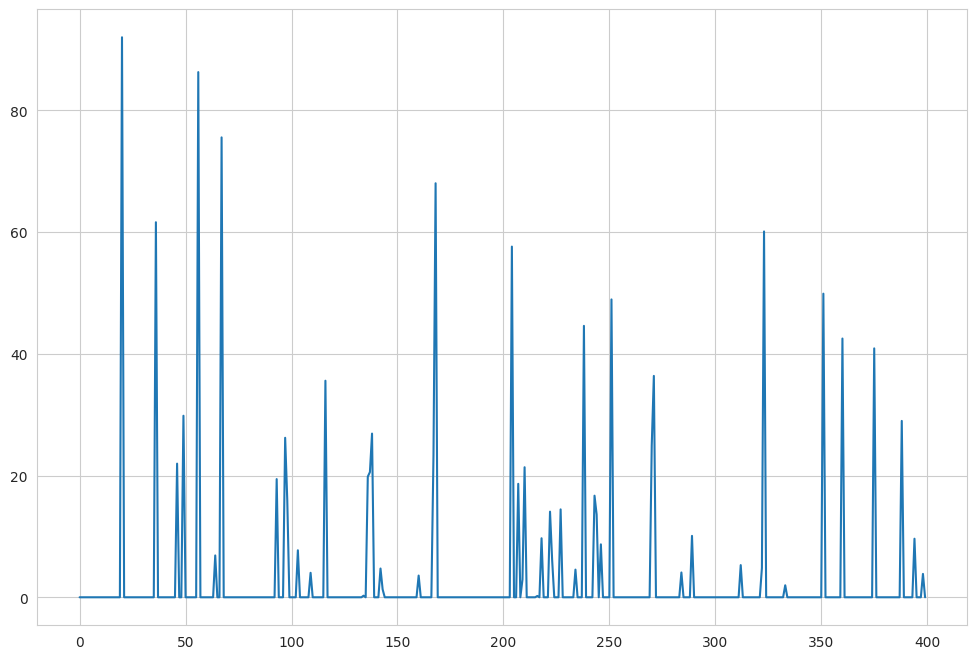

In [6]:
sns.lineplot(activity_matrix[:400,1000])

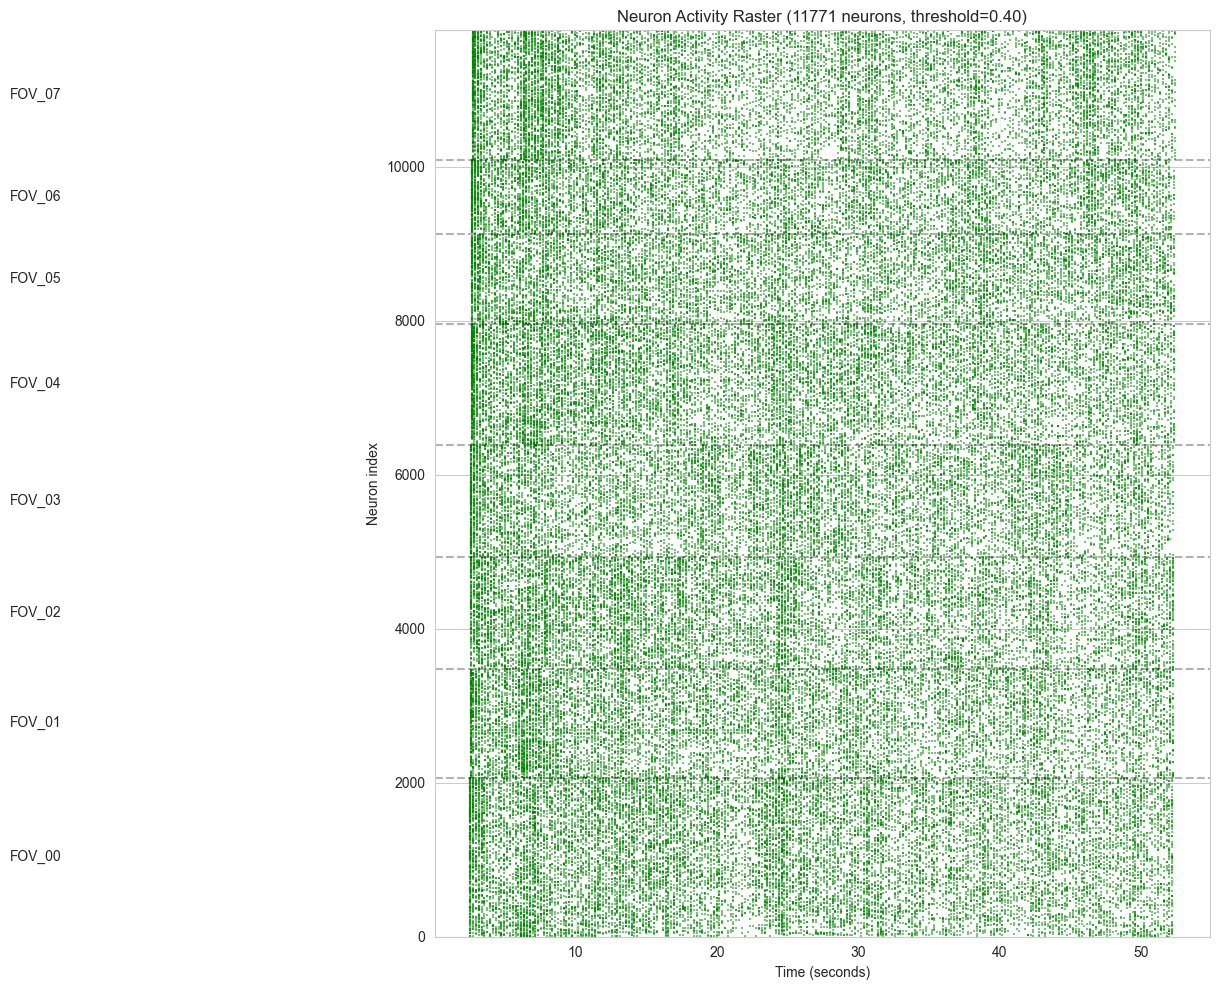

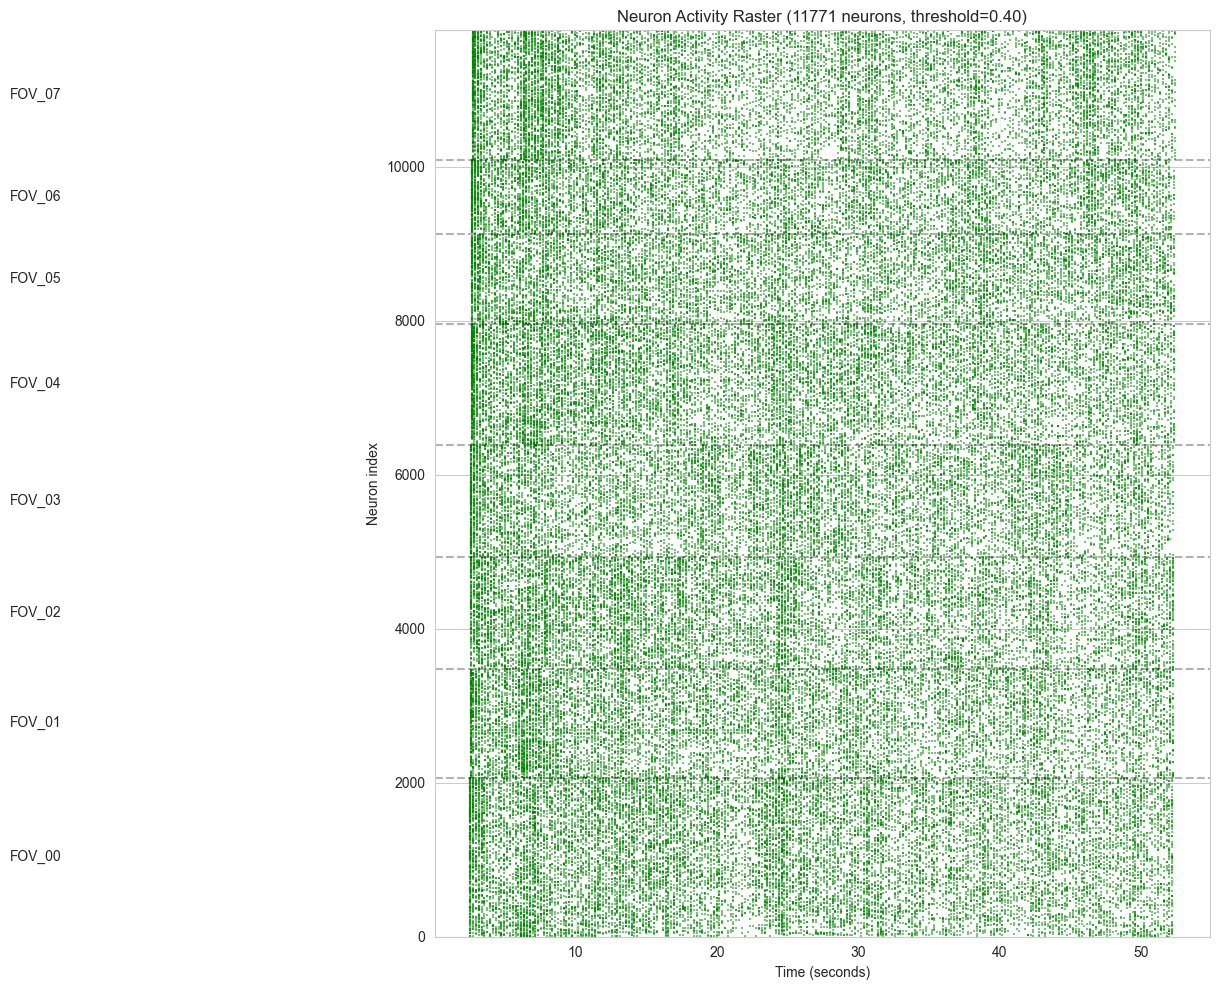

In [9]:
session.plot_binary_activity_heatmap(time_window=50, threshold=0.4)

Working with (21157, 11771) data (time x neurons)

=== INFORMATION CONTENT ANALYSIS ===
Mean neuron entropy: 0.291

=== DIMENSIONALITY ANALYSIS ===
Components for 80% variance: 1244/11771 (10.6%)
Components for 95% variance: 1805/11771 (15.3%)

=== TIMESCALE ANALYSIS ===


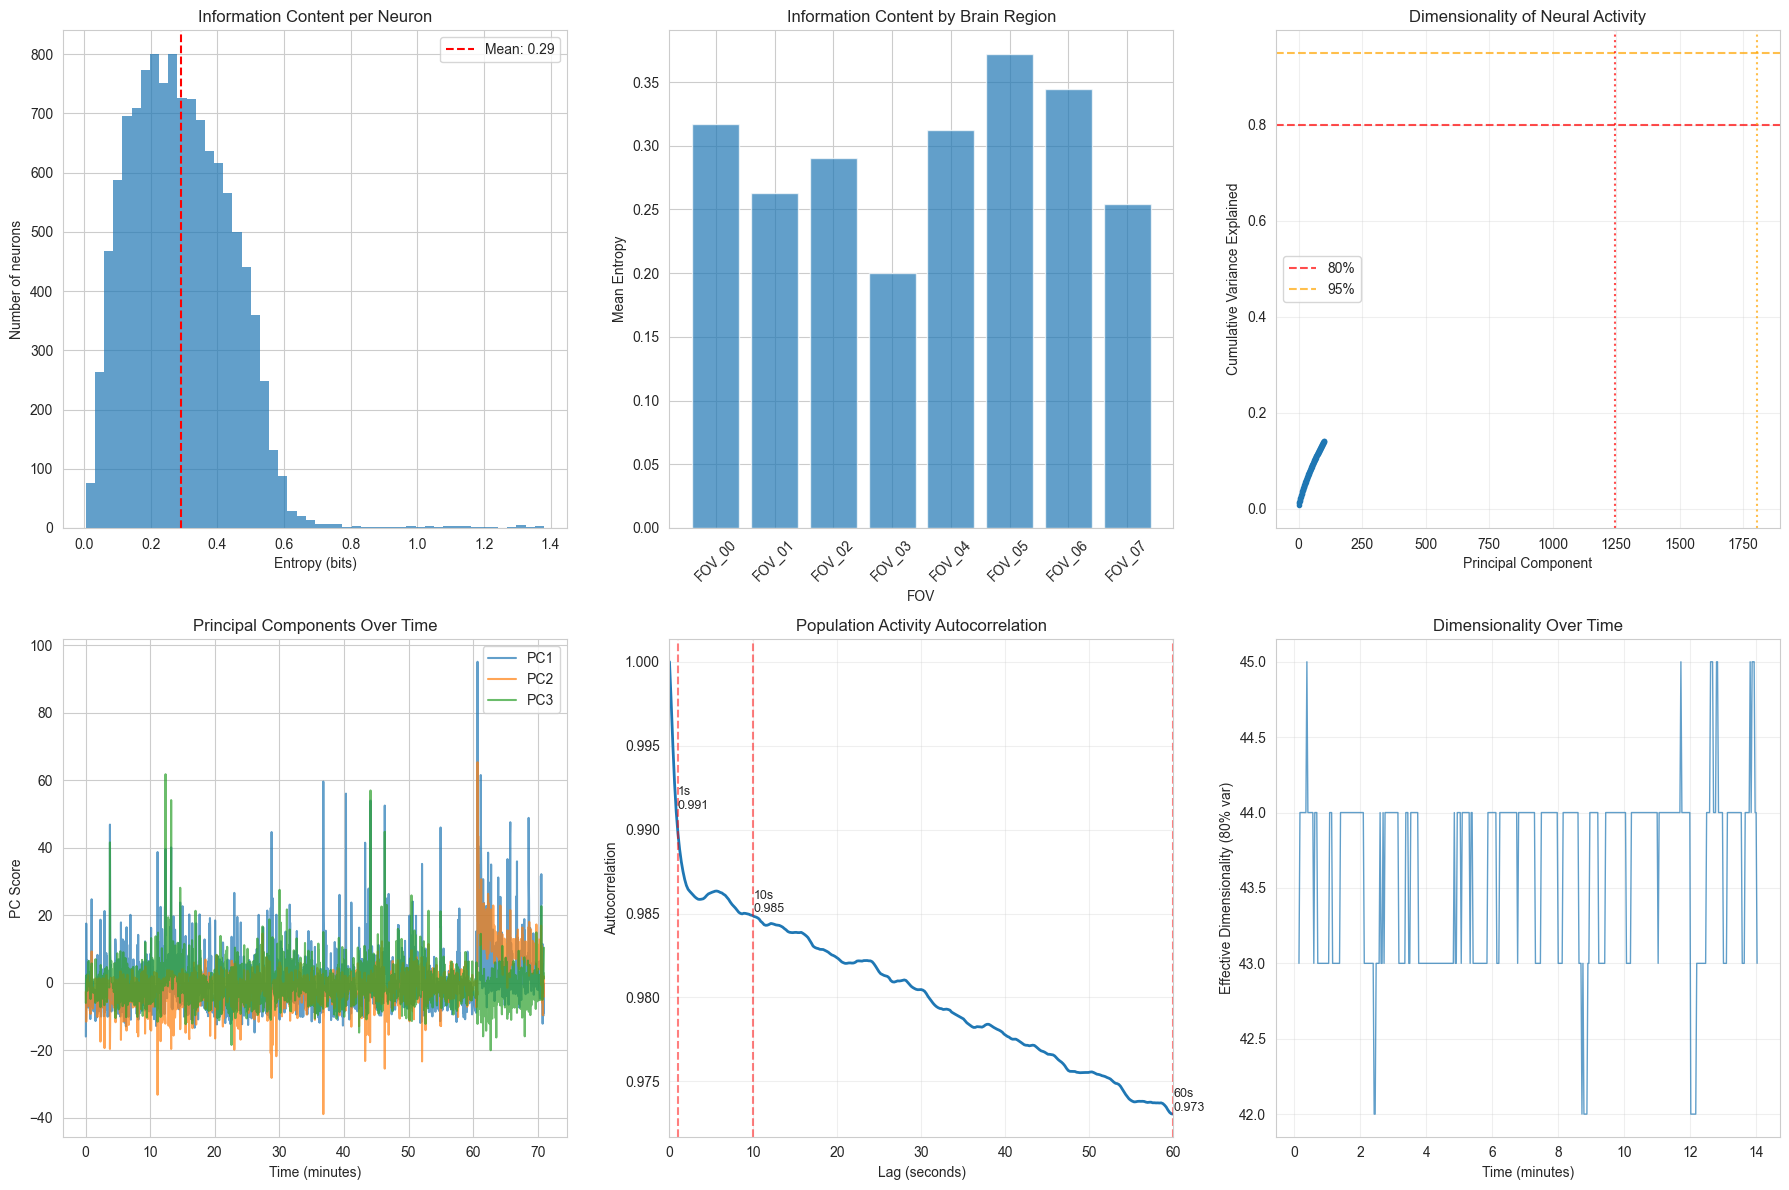


=== SUMMARY ===
Most informative FOV: FOV_05 (entropy: 0.372)
Least informative FOV: FOV_03 (entropy: 0.200)
Effective dimensionality: 1244/11771 neurons (10.6%)
Autocorrelation at 1s: 0.991
Autocorrelation at 10s: 0.985
Autocorrelation at 1min: 0.973
Mean sliding dimensionality: 43.6 ± 0.6


In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
from scipy.signal import correlate
import pandas as pd

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 12)

# Assume activity_matrix, timestamps, and session are already loaded
print(f"Working with {activity_matrix.shape} data (time x neurons)")

# =============================================================================
# 1. INFORMATION CONTENT ANALYSIS
# =============================================================================
print("\n=== INFORMATION CONTENT ANALYSIS ===")

# Calculate entropy for each neuron (measure of information content)
def calculate_neuron_entropy(activity, bins=20):
    """Calculate entropy for each neuron's activity distribution"""
    entropies = []
    for i in range(activity.shape[1]):
        hist, _ = np.histogram(activity[:, i], bins=bins, density=True)
        hist = hist[hist > 0]  # Remove zero bins
        entropies.append(entropy(hist))
    return np.array(entropies)

neuron_entropies = calculate_neuron_entropy(activity_matrix)
print(f"Mean neuron entropy: {np.mean(neuron_entropies):.3f}")

# Information content per FOV
fov_entropies = {}
neuron_idx = 0
for fov_name, fov in session.fovs.items():
    fov_activity = activity_matrix[:, neuron_idx:neuron_idx+fov.n_neurons]
    fov_entropies[fov_name] = np.mean(calculate_neuron_entropy(fov_activity))
    neuron_idx += fov.n_neurons

# =============================================================================
# 2. DIMENSIONALITY ANALYSIS (PCA)
# =============================================================================
print("\n=== DIMENSIONALITY ANALYSIS ===")

# Standardize data for PCA (sample every 10th timepoint for efficiency)
sample_step = 10
activity_sample = activity_matrix[::sample_step, :]
scaler = StandardScaler()
activity_scaled = scaler.fit_transform(activity_sample)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(activity_scaled)
explained_var = pca.explained_variance_ratio_

# Find number of components for 80% and 95% variance
cumvar = np.cumsum(explained_var)
n_80 = np.argmax(cumvar >= 0.8) + 1
n_95 = np.argmax(cumvar >= 0.95) + 1

print(f"Components for 80% variance: {n_80}/{activity_matrix.shape[1]} ({n_80/activity_matrix.shape[1]*100:.1f}%)")
print(f"Components for 95% variance: {n_95}/{activity_matrix.shape[1]} ({n_95/activity_matrix.shape[1]*100:.1f}%)")

# =============================================================================
# 3. TIMESCALE ANALYSIS
# =============================================================================
print("\n=== TIMESCALE ANALYSIS ===")

# Calculate population activity for correlation analysis
pop_activity = np.mean(activity_matrix > 0.1, axis=1)  # Fraction of active neurons

# Calculate autocorrelation at different lags
def calculate_autocorr(signal, max_lag_samples):
    """Calculate autocorrelation up to max_lag"""
    autocorr = correlate(signal, signal, mode='full')
    mid = len(autocorr) // 2
    autocorr = autocorr[mid:mid+max_lag_samples+1]
    return autocorr / autocorr[0]  # Normalize

# Define time lags to analyze
sampling_rate = 1 / np.mean(np.diff(timestamps))
lags_seconds = [1, 10, 60]  # 1s, 10s, 1min
max_lag_samples = int(60 * sampling_rate)  # 1 minute worth of samples

autocorr = calculate_autocorr(pop_activity, max_lag_samples)
lag_times = np.arange(len(autocorr)) / sampling_rate

# =============================================================================
# PLOTTING
# =============================================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Information content by neuron
axes[0,0].hist(neuron_entropies, bins=50, alpha=0.7, edgecolor='none')
axes[0,0].set_xlabel('Entropy (bits)')
axes[0,0].set_ylabel('Number of neurons')
axes[0,0].set_title('Information Content per Neuron')
axes[0,0].axvline(np.mean(neuron_entropies), color='red', linestyle='--', label=f'Mean: {np.mean(neuron_entropies):.2f}')
axes[0,0].legend()

# 2. Information content by FOV
fov_names = list(fov_entropies.keys())
fov_entropy_values = list(fov_entropies.values())
axes[0,1].bar(range(len(fov_names)), fov_entropy_values, alpha=0.7)
axes[0,1].set_xlabel('FOV')
axes[0,1].set_ylabel('Mean Entropy')
axes[0,1].set_title('Information Content by Brain Region')
axes[0,1].set_xticks(range(len(fov_names)))
axes[0,1].set_xticklabels(fov_names, rotation=45)

# 3. PCA explained variance
axes[0,2].plot(np.arange(1, min(100, len(explained_var))+1), 
               cumvar[:min(100, len(explained_var))], 'o-', markersize=3)
axes[0,2].axhline(0.8, color='red', linestyle='--', alpha=0.7, label='80%')
axes[0,2].axhline(0.95, color='orange', linestyle='--', alpha=0.7, label='95%')
axes[0,2].axvline(n_80, color='red', linestyle=':', alpha=0.7)
axes[0,2].axvline(n_95, color='orange', linestyle=':', alpha=0.7)
axes[0,2].set_xlabel('Principal Component')
axes[0,2].set_ylabel('Cumulative Variance Explained')
axes[0,2].set_title('Dimensionality of Neural Activity')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. First few PCs over time
time_sample = timestamps[::sample_step]
for i in range(3):
    axes[1,0].plot(time_sample/60, pca_result[:, i], alpha=0.7, label=f'PC{i+1}')
axes[1,0].set_xlabel('Time (minutes)')
axes[1,0].set_ylabel('PC Score')
axes[1,0].set_title('Principal Components Over Time')
axes[1,0].legend()

# 5. Autocorrelation function
axes[1,1].plot(lag_times, autocorr, linewidth=2)
axes[1,1].set_xlabel('Lag (seconds)')
axes[1,1].set_ylabel('Autocorrelation')
axes[1,1].set_title('Population Activity Autocorrelation')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xlim(0, 60)

# Add vertical lines for key timescales
for lag in lags_seconds:
    if lag <= 60:
        lag_idx = int(lag * sampling_rate)
        if lag_idx < len(autocorr):
            axes[1,1].axvline(lag, color='red', linestyle='--', alpha=0.5)
            axes[1,1].text(lag, autocorr[lag_idx], f'{lag}s\n{autocorr[lag_idx]:.3f}', 
                          verticalalignment='bottom', fontsize=9)

# 6. Effective dimensionality over time windows
window_size = int(60 * sampling_rate)  # 1-minute windows
step_size = int(10 * sampling_rate)    # 10-second steps

def sliding_dimensionality(data, window_size, step_size, var_threshold=0.8):
    """Calculate effective dimensionality in sliding windows"""
    dims = []
    times = []
    
    for start in range(0, data.shape[0] - window_size, step_size):
        window = data[start:start+window_size, :]
        window_scaled = StandardScaler().fit_transform(window)
        
        pca_window = PCA()
        pca_window.fit(window_scaled)
        cumvar_window = np.cumsum(pca_window.explained_variance_ratio_)
        
        dim = np.argmax(cumvar_window >= var_threshold) + 1
        dims.append(dim)
        times.append(timestamps[start + window_size//2])
    
    return np.array(times), np.array(dims)

# Calculate sliding dimensionality (subsample for efficiency)
subsample_factor = 5
data_sub = activity_matrix[::subsample_factor, :]
times_sub = timestamps[::subsample_factor]

window_times, sliding_dims = sliding_dimensionality(
    data_sub, 
    window_size // subsample_factor, 
    step_size // subsample_factor
)

axes[1,2].plot(window_times/60, sliding_dims, alpha=0.7, linewidth=1)
axes[1,2].set_xlabel('Time (minutes)')
axes[1,2].set_ylabel('Effective Dimensionality (80% var)')
axes[1,2].set_title('Dimensionality Over Time')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY STATISTICS
# =============================================================================
print(f"\n=== SUMMARY ===")
print(f"Most informative FOV: {max(fov_entropies, key=fov_entropies.get)} (entropy: {max(fov_entropies.values()):.3f})")
print(f"Least informative FOV: {min(fov_entropies, key=fov_entropies.get)} (entropy: {min(fov_entropies.values()):.3f})")
print(f"Effective dimensionality: {n_80}/{activity_matrix.shape[1]} neurons ({n_80/activity_matrix.shape[1]*100:.1f}%)")
print(f"Autocorrelation at 1s: {autocorr[int(1*sampling_rate)]:.3f}")
print(f"Autocorrelation at 10s: {autocorr[int(10*sampling_rate)]:.3f}")
if len(autocorr) > int(60*sampling_rate):
    print(f"Autocorrelation at 1min: {autocorr[int(60*sampling_rate)]:.3f}")
print(f"Mean sliding dimensionality: {np.mean(sliding_dims):.1f} ± {np.std(sliding_dims):.1f}")

=== DETAILED SUMMARY STATISTICS ===

--- Activity Value Ranges ---
Global min: 0.0000
Global max: 18622.3379
Global mean: 16.0608
Global median: 0.0000
Global std: 114.6837

Percentiles:
  1th: 0.0000
  5th: 0.0000
  10th: 0.0000
  25th: 0.0000
  50th: 0.0000
  75th: 0.0000
  90th: 24.7393
  95th: 74.6570
  99th: 287.1509

Fraction of exact zeros: 0.854 (85.4%)

Fraction above thresholds:
  >0.01: 0.1464 (14.64%)
  >0.1: 0.1462 (14.62%)
  >0.5: 0.1453 (14.53%)
  >1.0: 0.1442 (14.42%)
  >2.0: 0.1420 (14.20%)

--- Neuron-Level Statistics ---
Most active neuron (mean): 503.9446
Least active neuron (mean): 0.6359
Most active neuron (max): 18622.3379
Most active neuron (% time active): 45.0%
Completely silent neurons: 0/11771 (0.0%)
Very active neurons (>10% time): 11769/11771 (100.0%)

--- Top 100 Most Active Neurons by FOV ---
Top 100 neurons by FOV:
  FOV_00: 26/100 (26% of top 100, 1.3% of FOV_00)
  FOV_02: 24/100 (24% of top 100, 1.7% of FOV_02)
  FOV_04: 22/100 (22% of top 100, 1.4% o

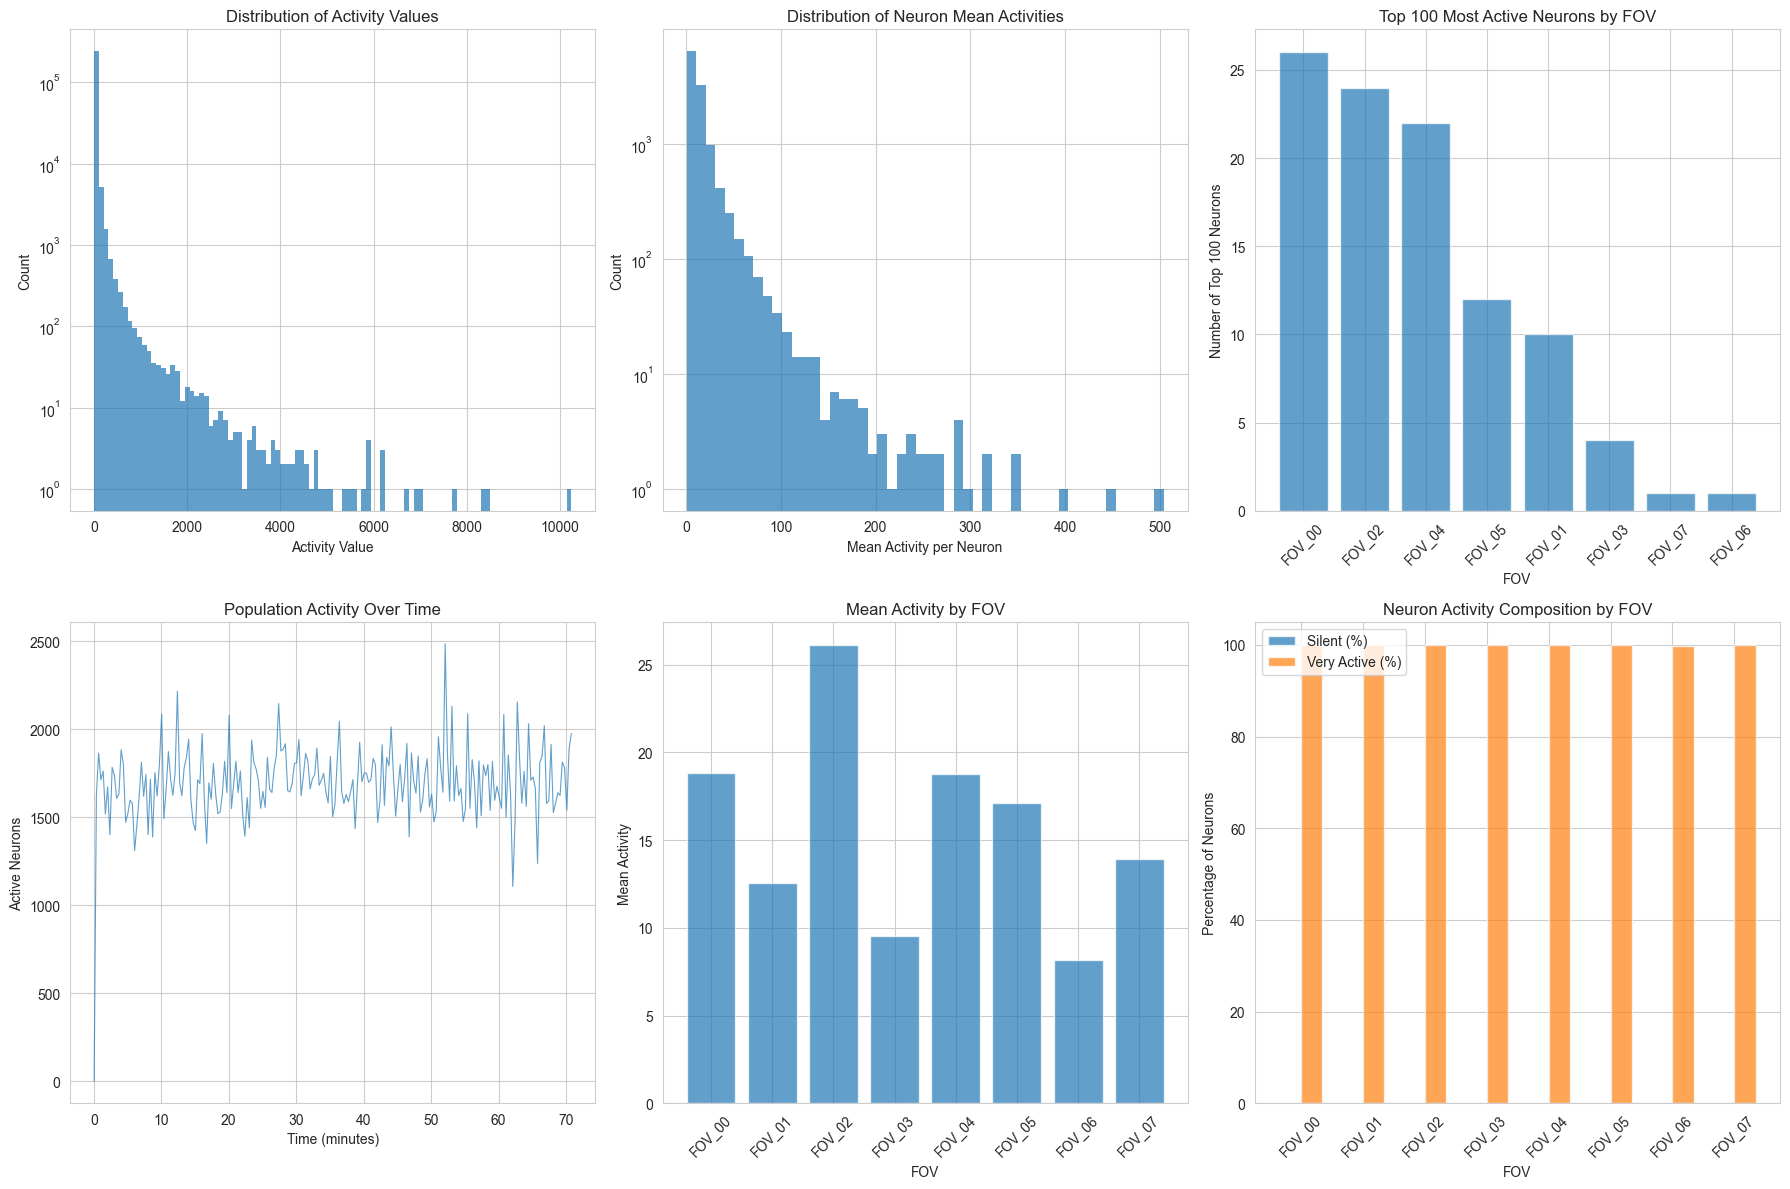


=== FINAL SUMMARY ===
Dataset: 21157 timepoints × 11771 neurons
Duration: 71.0 minutes
Most active FOV: FOV_02 (mean activity: 26.1335)
Most represented in top 100: FOV_00 (26 neurons)
Sparsity: 85.4% exact zeros, 85.4% below threshold
Dynamic range: 169.8x above mean non-zero


In [11]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

print("=== DETAILED SUMMARY STATISTICS ===")

# =============================================================================
# 1. ACTIVITY VALUE RANGES
# =============================================================================
print("\n--- Activity Value Ranges ---")
print(f"Global min: {np.min(activity_matrix):.4f}")
print(f"Global max: {np.max(activity_matrix):.4f}")
print(f"Global mean: {np.mean(activity_matrix):.4f}")
print(f"Global median: {np.median(activity_matrix):.4f}")
print(f"Global std: {np.std(activity_matrix):.4f}")

# Percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
perc_values = np.percentile(activity_matrix, percentiles)
print(f"\nPercentiles:")
for p, v in zip(percentiles, perc_values):
    print(f"  {p}th: {v:.4f}")

# Fraction of zeros
zero_fraction = np.mean(activity_matrix == 0)
print(f"\nFraction of exact zeros: {zero_fraction:.3f} ({zero_fraction*100:.1f}%)")

# Fraction above different thresholds
thresholds = [0.01, 0.1, 0.5, 1.0, 2.0]
print(f"\nFraction above thresholds:")
for thresh in thresholds:
    frac = np.mean(activity_matrix > thresh)
    print(f"  >{thresh}: {frac:.4f} ({frac*100:.2f}%)")

# =============================================================================
# 2. NEURON-LEVEL STATISTICS
# =============================================================================
print("\n--- Neuron-Level Statistics ---")

# Calculate per-neuron statistics
neuron_means = np.mean(activity_matrix, axis=0)
neuron_maxes = np.max(activity_matrix, axis=0)
neuron_stds = np.std(activity_matrix, axis=0)
neuron_active_fraction = np.mean(activity_matrix > 0.1, axis=0)  # Fraction of time active

print(f"Most active neuron (mean): {np.max(neuron_means):.4f}")
print(f"Least active neuron (mean): {np.min(neuron_means):.4f}")
print(f"Most active neuron (max): {np.max(neuron_maxes):.4f}")
print(f"Most active neuron (% time active): {np.max(neuron_active_fraction)*100:.1f}%")

# Silent neurons
silent_neurons = np.sum(neuron_maxes == 0)
print(f"Completely silent neurons: {silent_neurons}/{len(neuron_means)} ({silent_neurons/len(neuron_means)*100:.1f}%)")

# Very active neurons
very_active = np.sum(neuron_active_fraction > 0.1)  # Active >10% of time
print(f"Very active neurons (>10% time): {very_active}/{len(neuron_means)} ({very_active/len(neuron_means)*100:.1f}%)")

# =============================================================================
# 3. TOP 100 MOST ACTIVE NEURONS BY FOV
# =============================================================================
print("\n--- Top 100 Most Active Neurons by FOV ---")

# Get indices of top 100 most active neurons (by mean activity)
top_100_indices = np.argsort(neuron_means)[-100:][::-1]  # Top 100, sorted descending

# Map neuron indices to FOVs
def get_neuron_fov_mapping(session):
    """Create mapping from neuron index to FOV name"""
    neuron_to_fov = {}
    neuron_idx = 0
    
    for fov_name, fov in session.fovs.items():
        for i in range(fov.n_neurons):
            neuron_to_fov[neuron_idx] = fov_name
            neuron_idx += 1
    
    return neuron_to_fov

neuron_to_fov = get_neuron_fov_mapping(session)

# Count top neurons by FOV
top_100_fovs = [neuron_to_fov[idx] for idx in top_100_indices]
fov_counts = pd.Series(top_100_fovs).value_counts()

print("Top 100 neurons by FOV:")
for fov, count in fov_counts.items():
    total_in_fov = session.fovs[fov].n_neurons
    percentage = count/total_in_fov*100
    print(f"  {fov}: {count}/100 ({count}% of top 100, {percentage:.1f}% of {fov})")

# =============================================================================
# 4. TEMPORAL STATISTICS
# =============================================================================
print("\n--- Temporal Statistics ---")

# Population activity over time
pop_activity = np.sum(activity_matrix > 0.1, axis=1)  # Number of active neurons per timepoint
pop_mean_activity = np.mean(activity_matrix, axis=1)  # Mean activity per timepoint

print(f"Max simultaneous active neurons: {np.max(pop_activity)}/{activity_matrix.shape[1]} ({np.max(pop_activity)/activity_matrix.shape[1]*100:.1f}%)")
print(f"Min simultaneous active neurons: {np.min(pop_activity)}")
print(f"Mean simultaneous active neurons: {np.mean(pop_activity):.1f}")

# Most/least active time periods
most_active_time = timestamps[np.argmax(pop_activity)]
least_active_time = timestamps[np.argmin(pop_activity)]
print(f"Most active timepoint: {most_active_time:.1f}s ({most_active_time/60:.1f}min)")
print(f"Least active timepoint: {least_active_time:.1f}s ({least_active_time/60:.1f}min)")

# =============================================================================
# 5. FOV-LEVEL COMPARISONS
# =============================================================================
print("\n--- FOV-Level Comparisons ---")

fov_stats = {}
neuron_idx = 0

for fov_name, fov in session.fovs.items():
    fov_activity = activity_matrix[:, neuron_idx:neuron_idx+fov.n_neurons]
    
    fov_stats[fov_name] = {
        'n_neurons': fov.n_neurons,
        'mean_activity': np.mean(fov_activity),
        'max_activity': np.max(fov_activity),
        'active_fraction': np.mean(fov_activity > 0.1),
        'silent_neurons': np.sum(np.max(fov_activity, axis=0) == 0),
        'very_active_neurons': np.sum(np.mean(fov_activity > 0.1, axis=0) > 0.1)
    }
    
    neuron_idx += fov.n_neurons

# Create DataFrame for easier viewing
fov_df = pd.DataFrame(fov_stats).T
fov_df['silent_pct'] = fov_df['silent_neurons'] / fov_df['n_neurons'] * 100
fov_df['very_active_pct'] = fov_df['very_active_neurons'] / fov_df['n_neurons'] * 100

print("FOV Statistics:")
print(fov_df.round(4))

# =============================================================================
# 6. VISUALIZATION
# =============================================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Activity value distribution (log scale)
axes[0,0].hist(activity_matrix.flatten()[::1000], bins=100, alpha=0.7, edgecolor='none')  # Sample for speed
axes[0,0].set_xlabel('Activity Value')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Distribution of Activity Values')
axes[0,0].set_yscale('log')

# 2. Neuron activity distribution
axes[0,1].hist(neuron_means, bins=50, alpha=0.7, edgecolor='none')
axes[0,1].set_xlabel('Mean Activity per Neuron')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Distribution of Neuron Mean Activities')
axes[0,1].set_yscale('log')

# 3. Top 100 neurons by FOV
axes[0,2].bar(range(len(fov_counts)), fov_counts.values, alpha=0.7)
axes[0,2].set_xlabel('FOV')
axes[0,2].set_ylabel('Number of Top 100 Neurons')
axes[0,2].set_title('Top 100 Most Active Neurons by FOV')
axes[0,2].set_xticks(range(len(fov_counts)))
axes[0,2].set_xticklabels(fov_counts.index, rotation=45)

# 4. Population activity over time (downsampled)
downsample = 100
axes[1,0].plot(timestamps[::downsample]/60, pop_activity[::downsample], alpha=0.7, linewidth=0.8)
axes[1,0].set_xlabel('Time (minutes)')
axes[1,0].set_ylabel('Active Neurons')
axes[1,0].set_title('Population Activity Over Time')

# 5. FOV activity comparison
axes[1,1].bar(range(len(fov_df)), fov_df['mean_activity'], alpha=0.7)
axes[1,1].set_xlabel('FOV')
axes[1,1].set_ylabel('Mean Activity')
axes[1,1].set_title('Mean Activity by FOV')
axes[1,1].set_xticks(range(len(fov_df)))
axes[1,1].set_xticklabels(fov_df.index, rotation=45)

# 6. FOV neuron composition
width = 0.35
x = np.arange(len(fov_df))
axes[1,2].bar(x - width/2, fov_df['silent_pct'], width, label='Silent (%)', alpha=0.7)
axes[1,2].bar(x + width/2, fov_df['very_active_pct'], width, label='Very Active (%)', alpha=0.7)
axes[1,2].set_xlabel('FOV')
axes[1,2].set_ylabel('Percentage of Neurons')
axes[1,2].set_title('Neuron Activity Composition by FOV')
axes[1,2].set_xticks(x)
axes[1,2].set_xticklabels(fov_df.index, rotation=45)
axes[1,2].legend()

plt.tight_layout()
plt.show()

# =============================================================================
# 7. FINAL SUMMARY
# =============================================================================
print(f"\n=== FINAL SUMMARY ===")
print(f"Dataset: {activity_matrix.shape[0]} timepoints × {activity_matrix.shape[1]} neurons")
print(f"Duration: {timestamps[-1]/60:.1f} minutes")
print(f"Most active FOV: {fov_df['mean_activity'].idxmax()} (mean activity: {fov_df['mean_activity'].max():.4f})")
print(f"Most represented in top 100: {fov_counts.index[0]} ({fov_counts.iloc[0]} neurons)")
print(f"Sparsity: {zero_fraction*100:.1f}% exact zeros, {(1-np.mean(activity_matrix > 0.1))*100:.1f}% below threshold")
print(f"Dynamic range: {np.max(activity_matrix)/np.mean(activity_matrix[activity_matrix > 0]):.1f}x above mean non-zero")